In [1]:
import os
import sys
import copy
import random
import json
from tqdm import tqdm, trange

In [2]:
import numpy as np
import cv2
import albumentations as alb

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load dataset

In [5]:
def get_image_level(image_path, mask_path, size=(256, 256), aug=None, pad=48, border=128):
    # Read image-mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)[:,:,0]
    h, w = mask.shape
    
    # Read levels value
    levels = np.max(mask)
    
    # Do augumentation
    if aug:
        sample = aug(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # Calculate center point to crop
    half_size = int(mask.shape[0] / 2)
    sh, sw = half_size, None
    for i in range(mask.shape[1]):
        v = mask[half_size, i]
        if v != 0:
            sw = i
            break
    if sw is None:
        raise ValueError('Object box not found')
    
    h1, h2 = int(sh - size[0] / 2), int(sh + size[0] / 2)
    w1, w2 = int(sw - size[1] / 2), int(sw + size[1] / 2)
    
    # Make visible area around mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (border, border))
    image_mask = mask.copy()
    image_mask = cv2.dilate(image_mask, kernel, iterations=1).clip(0, 1)
    image = image * np.stack([image_mask, image_mask, image_mask], axis=-1)

    # Crop and copy
    mask = mask[h1:h2, w1:w2]
    result = image.copy()[h1:h2, w1:w2, :]
    return result, levels

In [7]:
image_prefix = 'i_'
mask_prefix = 'm_'

# Let's fileter data
min_level = 1
max_level = 22

# dataset_path = '/home/hancharenka/work/datasets/dataset_v1/'
dataset_path = '/home/user3/work/data/by_z_regression/dataset_v1'

folder_list = [os.path.join(dataset_path, fn) for fn in os.listdir(dataset_path)
               if os.path.isdir(os.path.join(dataset_path, fn)) if not 'minsk' in fn] # Remove Minsk

dataset_files = []
for k, folder in enumerate(folder_list, start=1):
    print('Started', k, 'of', len(folder_list))
    dataset_name = folder.split('_')[-1]
    dataset_items = [fn[len(mask_prefix): ] for fn in os.listdir(folder) if os.path.isfile(os.path.join(folder, fn)) and fn.startswith(mask_prefix)]
    for n in trange(len(dataset_items)):
        dataset_item = dataset_items[n]
        ip, mp = (os.path.join(folder, image_prefix + dataset_item), os.path.join(folder, mask_prefix + dataset_item))
        try:
            i, l = get_image_level(ip, mp)
            l = float(l)
            if l < min_level:
                continue
            if l > max_level:
                continue
            if i.shape[0] != 256 or i.shape[1] != 256:
                continue
        except Exception as e:
            continue
        dataset_files.append((ip, mp, dataset_name, int(l)))

Started 1 of 8


100%|███████████████████████████████████████| 1624/1624 [01:22<00:00, 19.68it/s]


Started 2 of 8


100%|█████████████████████████████████████████| 767/767 [00:45<00:00, 16.70it/s]


Started 3 of 8


 25%|██████████                              | 990/3922 [00:48<02:22, 20.54it/s]


KeyboardInterrupt: 

In [8]:
train_files, valid_files = train_test_split(dataset_files, test_size=0.3, train_size=0.7, random_state=4, shuffle=True)

train_dataset_list = []
train_dataset_dict = {}
for ip, mp, dataset_name, l in train_files:
    if dataset_name not in train_dataset_dict:
        train_dataset_dict[dataset_name] = {}
    if l not in train_dataset_dict[dataset_name]:
        train_dataset_dict[dataset_name][l] = []
    train_dataset_dict[dataset_name][l].append((ip, mp))
    train_dataset_list.append((ip, mp, dataset_name, l))
            
print('Train Loaded', len(train_dataset_list))


valid_dataset_list = []
valid_dataset_dict = {}
for ip, mp, dataset_name, l in valid_files:
    if dataset_name not in valid_dataset_dict:
        valid_dataset_dict[dataset_name] = {}
    if l not in valid_dataset_dict[dataset_name]:
        valid_dataset_dict[dataset_name][l] = []
    valid_dataset_dict[dataset_name][l].append((ip, mp))
    valid_dataset_list.append((ip, mp, dataset_name, l))
            
print('Val Loaded', len(valid_dataset_list))

Train Loaded 2349
Val Loaded 1008


In [9]:
def get_random_negative_sample(dataset_dict, a, mode='level'):
    fi, fm, ds, lv = a
    negative_dataset_levels = [k for k in dataset_dict[ds].keys() if not k == lv]
    
    if mode == 'level':
        random_level = random.choice(negative_dataset_levels)
        random_item = random.choice(dataset_dict[ds][random_level])
        return random_item
    elif mode == 'item':
        all_negetive_items = []
        for i in negative_dataset_levels:
            all_negetive_items.extend(dataset_dict[ds][random_level])
        random_item = random.choice(all_negetive_items)
        return random_item
    else:
        raise ValueError()
        
def get_random_positive_sample(dataset_dict, a):
    fi, fm, ds, lv = a
    random_item = random.choice([i for i in dataset_dict[ds][lv] if i != a])
    return random_item

In [10]:
min_count = 6
train_dataset_dict_f = copy.deepcopy(train_dataset_dict)
for n, ds in train_dataset_dict_f.items():
    print('\n{}'.format(n))
    skip_list = []
    for l, v in ds.items():
        element_count = len(v)
        if element_count < min_count:
            skip_list.append(l)
            continue
        print(int(l), '=', element_count)
    for s in skip_list:
        ds.pop(s)
        
train_dataset_list_f = []
for d, v1 in train_dataset_dict_f.items():
    for lv, v2 in v1.items():
        v = [(ip, fp, d, lv) for ip, fp in v2]
        train_dataset_list_f.extend(v)
print('Loaded', len(train_dataset_list_f))


bobruisk
5 = 201
2 = 126
9 = 137
3 = 42
4 = 24
14 = 6

hrodna
2 = 282
12 = 10
9 = 93
3 = 89
5 = 108
10 = 33
8 = 6
6 = 7
4 = 35
7 = 11

brest
7 = 21
9 = 245
5 = 296
2 = 209
12 = 32
3 = 69
4 = 46
10 = 125
8 = 11
6 = 13
18 = 11
14 = 10
16 = 7
11 = 8
Loaded 2313


In [11]:
min_count = 2
valid_dataset_dict_f = copy.deepcopy(valid_dataset_dict)
for n, ds in valid_dataset_dict_f.items():
    print('\n{}'.format(n))
    skip_list = []
    for l, v in ds.items():
        element_count = len(v)
        if element_count < min_count:
            skip_list.append(l)
            continue
        print(int(l), '=', element_count)
    for s in skip_list:
        ds.pop(s)
        
valid_dataset_list_f = []
for d, v1 in valid_dataset_dict_f.items():
    for lv, v2 in v1.items():
        v = [(ip, fp, d, lv) for ip, fp in v2]
        valid_dataset_list_f.extend(v)
print('Loaded', len(valid_dataset_list_f))


brest
12 = 16
5 = 118
9 = 114
3 = 42
2 = 85
10 = 59
8 = 3
18 = 5
14 = 4
4 = 18
7 = 9
6 = 8

hrodna
3 = 49
2 = 115
5 = 49
4 = 15
9 = 38
10 = 19
13 = 3
7 = 3
14 = 2
12 = 5
16 = 2

bobruisk
3 = 23
5 = 85
2 = 48
9 = 50
4 = 12
Loaded 999


In [12]:
class ClRegDataset(BaseDataset):
    
    def __init__(self, dataset_files, dataset_map, augmentation=None, skip_list=None, fp_out=False):
        self.dataset_files = dataset_files
        self.dataset_map = dataset_map
        self.augmentation = augmentation
        self.pad = 48
        self.border = 128
        self.output_size = (256, 256)
        self.skip_list = skip_list
        self.fp_out = fp_out
    
    def __getitem__(self, i):
        a = self.dataset_files[i]
        image_path, mask_path, ds, lv = a

        # Image
        image, levels = get_image_level(image_path, mask_path,
                                       size=self.output_size,
                                       aug=None, pad=self.pad, border=self.border)

        # Positive
        pos = get_random_positive_sample(self.dataset_map, a)
        pos_image_path, pos_mask_path = pos
        pos_image, pos_levels = get_image_level(pos_image_path, pos_mask_path,
                                                size=self.output_size,
                                                aug=None, pad=self.pad, border=self.border)

        # Negative
        neg = get_random_negative_sample(self.dataset_map, a)
        neg_image_path, neg_mask_path = neg
        neg_image, neg_levels = get_image_level(neg_image_path, neg_mask_path,
                                                size=self.output_size,
                                                aug=None, pad=self.pad, border=self.border)
        if self.fp_out:
            return (image_path, mask_path), (pos_image_path, pos_mask_path), (neg_image_path, neg_mask_path)
        
        if self.augmentation:
            sample = self.augmentation(image=image, pos_image=pos_image, neg_image=neg_image)
            image, pos_image, neg_image = sample['image'], sample['pos_image'], sample['neg_image']
            
            
        image, levels = torch.tensor(image.copy(), dtype=torch.float), torch.tensor(levels, dtype=torch.float)
        pos_image, pos_levels = torch.tensor(pos_image.copy(), dtype=torch.float), torch.tensor(pos_levels, dtype=torch.float)
        neg_image, neg_levels = torch.tensor(neg_image.copy(), dtype=torch.float), torch.tensor(neg_levels, dtype=torch.float)
        return image, levels, pos_image, pos_levels, neg_image, neg_levels
        
    def __len__(self):
        return len(self.dataset_files)


class ClRegDatasetStrict(BaseDataset):
    
    def __init__(self, dataset_files, augmentation=None, skip_list=None, fp_out=False):
        self.dataset_files = dataset_files
        self.augmentation = augmentation
        self.pad = 48
        self.border = 128
        self.output_size = (256, 256)
        self.skip_list = skip_list
        self.fp_out = fp_out
    
    def __getitem__(self, i):
        a = self.dataset_files[i]
        ((image_path, mask_path), (pos_image_path, pos_mask_path), (neg_image_path, neg_mask_path)) = a

        # Image
        image, levels = get_image_level(image_path, mask_path,
                                       size=self.output_size,
                                       aug=self.augmentation, pad=self.pad, border=self.border)

        # Positive
        pos_image, pos_levels = get_image_level(pos_image_path, pos_mask_path,
                                                size=self.output_size,
                                                aug=self.augmentation, pad=self.pad, border=self.border)

        # Negative
        neg_image, neg_levels = get_image_level(neg_image_path, neg_mask_path,
                                                size=self.output_size,
                                                aug=self.augmentation, pad=self.pad, border=self.border)
        image, levels = torch.tensor(image.copy(), dtype=torch.float), torch.tensor(levels, dtype=torch.float)
        pos_image, pos_levels = torch.tensor(pos_image.copy(), dtype=torch.float), torch.tensor(pos_levels, dtype=torch.float)
        neg_image, neg_levels = torch.tensor(neg_image.copy(), dtype=torch.float), torch.tensor(neg_levels, dtype=torch.float)
        return image, levels, pos_image, pos_levels, neg_image, neg_levels
        
    def __len__(self):
        return len(self.dataset_files)

In [13]:
def get_training_augmentation():
    train_transform = [

        # Geometric transforms
        alb.Flip(p=0.75),
        alb.Transpose(p=0.5),
        alb.RandomRotate90(p=0.75),
        alb.ShiftScaleRotate(scale_limit=(-0.3, 0.3), shift_limit=0, rotate_limit=45, p=0.9),
        alb.Perspective(p=0.2),

        # Color transformations
        alb.OneOf([
            alb.RGBShift(p=1),
            alb.HueSaturationValue(p=1),
            alb.ChannelShuffle(p=0.2),
            alb.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
            alb.RandomGamma(p=1),
            alb.CLAHE(p=1),
        ], p=1),


        # Noise
        alb.OneOf([
            alb.GaussNoise(p=1),  
            alb.Emboss(p=1),
            alb.Sharpen(p=1),
            alb.JpegCompression(p=1),
        ], p=1),


        # Blur
        alb.OneOf([
            alb.Blur(blur_limit=3, p=1),
            alb.GaussianBlur(blur_limit=3, p=1),
            alb.MedianBlur(blur_limit=3, p=1),
            alb.MotionBlur(blur_limit=3, p=1),        
        ], p=1),

        # Cloud Shadow
        alb.RandomShadow(shadow_roi=(0,0,1,1), num_shadows_upper=1, shadow_dimension=4, p=0.02),

        alb.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        alb.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return alb.Compose(train_transform, additional_targets={'pos_image': 'image', 'neg_image': 'image'})

/home/user3/work/code/infer/venv38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
/home/user3/work/code/infer/venv38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1952: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


tensor(2.)


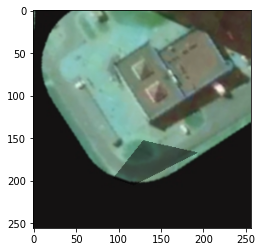

tensor(2.)


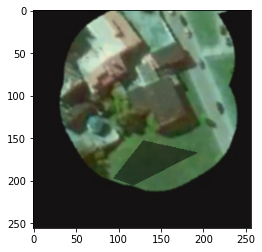

tensor(4.)


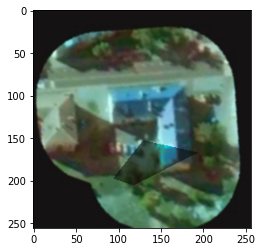

In [14]:
# Lets look at data we have
train_dataset = ClRegDataset(train_dataset_list_f, train_dataset_dict_f, augmentation=get_training_augmentation())
image, level, pimage, plevel, nimage, nlevel = train_dataset[random.randint(0, len(train_dataset))] # get some sample
print(level)
plt.imshow(image.numpy().astype('uint8'))
plt.show()

print(plevel)
plt.imshow(pimage.numpy().astype('uint8'))
plt.show()

print(nlevel)
plt.imshow(nimage.numpy().astype('uint8'))
plt.show()

tensor(2.)


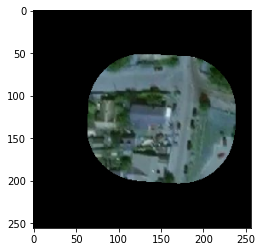

tensor(2.)


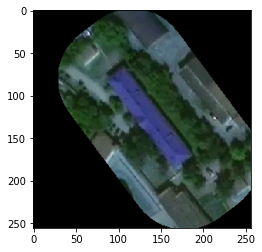

tensor(9.)


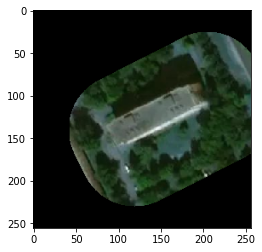

100%|█████████████████████████████████████████| 512/512 [01:19<00:00,  6.44it/s]


In [15]:
# Lets look at data we have
random.shuffle(valid_dataset_list_f)
full_valid_dataset = ClRegDataset(valid_dataset_list_f, valid_dataset_dict_f)
image, level, pimage, plevel, nimage, nlevel = full_valid_dataset[random.randint(0, len(full_valid_dataset))] # get some sample
print(level)
plt.imshow(image.numpy().astype('uint8'))
plt.show()

print(plevel)
plt.imshow(pimage.numpy().astype('uint8'))
plt.show()

print(nlevel)
plt.imshow(nimage.numpy().astype('uint8'))
plt.show()

full_valid_dataset.fp_out = True
valid_items = [full_valid_dataset[i] for i in trange(512)]
full_valid_dataset.fp_out = False

tensor(9.)


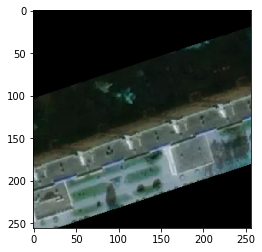

tensor(9.)


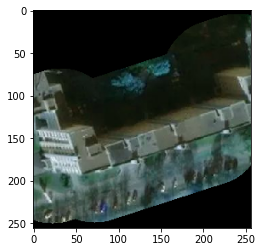

tensor(14.)


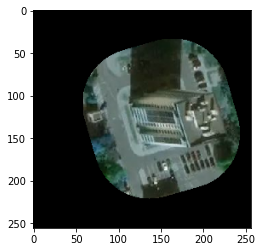

In [31]:
valid_dataset = ClRegDatasetStrict(valid_items)
image, level, pimage, plevel, nimage, nlevel = valid_dataset[random.randint(0, len(valid_dataset))] # get some sample

print(level)
plt.imshow(image.numpy().astype('uint8'))
plt.show()

print(plevel)
plt.imshow(pimage.numpy().astype('uint8'))
plt.show()

print(nlevel)
plt.imshow(nimage.numpy().astype('uint8'))
plt.show()

In [17]:
def preprocess_f(x):
    x = x.float()

    x.div_(255.0)

    x[:,0, :, :].add_(-0.485)
    x[:,1, :, :].add_(-0.456)
    x[:,2, :, :].add_(-0.406)

    x[:,0, :, :].div_(0.229)
    x[:,1, :, :].div_(0.224)
    x[:,2, :, :].div_(0.225)
    return x


def calc_euclidean(x1, x2):
    return (x1 - x2).pow(2).sum()


class AdaptivePoolingHead(nn.Sequential):
    def __init__(self, pooling="avg"):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        super().__init__(pool)
    

class ClassificationHead(nn.Sequential):

    def __init__(self, in_channels, classes, pooling="avg", dropout=0.2):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        flatten = nn.Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, classes, bias=True)
        activation = nn.Softmax()
        super().__init__(pool, flatten, dropout, linear, activation)
        
class RegressionHead(nn.Sequential):

    def __init__(self, in_channels, pooling="avg", dropout=0.2):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        flatten = nn.Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, 1, bias=True)
        activation = nn.ReLU6()
        super().__init__(pool, flatten, dropout, linear, activation)

class OsmNet(torch.nn.Module):
    def __init__(self, source_model, backbone_channels=512, num_classes=16):
        super(OsmNet, self).__init__()
        self.source_model = source_model
        # self.head = ClassificationHead(backbone_channels, 1)
        # self.head = RegressionHead(backbone_channels)

    def forward(self, x):
        x = x.float()
        x = preprocess_f(x)
        x = self.source_model.forward_features(x)
        # x = self.head(x)
        return x


net = OsmNet(timm.create_model('vgg11'))

In [24]:
BEST_PATH = 'byosm/_best_vgg11.pth'
CUDA = "cuda:0"
device = torch.device(CUDA) # if torch.cuda.is_available() else CPU)

In [25]:
CUDA = "cuda:0"
CPU = "cpu"
device = torch.device(CUDA) # if torch.cuda.is_available() else CPU)

NET = net
NET.to(device)

VALUE_RANGE = 25

BATCH_SIZE = 8
EPOCH_COUNT = 25
CRITERION = nn.TripletMarginLoss()
OPTIMIZER = optim.Adam(NET.parameters(), lr=1e-4)
SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, 'min', factor=0.2, patience=5)

TRAIN_LOADER = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=4)
VALID_LOADER = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                           shuffle=False, num_workers=4)

LOSS_PRINT_STEP = 1
BEST_PATH = '_best.pth'

EPOCH_KEY = 'EPOCH'
BATCH_KEY = 'BATCH'
LOSS_KEY = 'LOSS'
VALID_LOSS_KEY = 'VALID_LOSS'
TRAIN_LOSS_KEY = 'TRAIN_LOSS'
VALID_ACC_KEY = 'VALID_ACC'
LR_KEY = 'LR'

TRAIN_HISTORY = []
VALID_HISTORY = []

best_loss = float('inf')
for epoch in range(1, EPOCH_COUNT+1):  # loop over the dataset multiple times
    train_count = len(TRAIN_LOADER)
    
    # zero the parameter gradients
    OPTIMIZER.zero_grad()
    NET.train()
    total_train_loss = 0.0
    with tqdm(TRAIN_LOADER, position=0) as train_data_iterator:
        for batch_n, data in enumerate(train_data_iterator, 1):
            
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                image, _, pimage, _, nimage, _ = data
                image, pimage, nimage = image.to(device), pimage.to(device), nimage.to(device)
                image, pimage, nimage = torch.transpose(image, 1, 3), torch.transpose(pimage, 1, 3), torch.transpose(nimage, 1, 3)
                    
            anchor = NET(image)
            pos = NET(pimage)
            neg = NET(nimage)
            
            loss = CRITERION(anchor, pos, neg)
            loss.backward()
            OPTIMIZER.step()
            OPTIMIZER.zero_grad()
            total_train_loss += float(loss)
            # print statistics
            history_item = {EPOCH_KEY: epoch,
                            BATCH_KEY: batch_n,
                            LOSS_KEY: loss.item()}
            train_data_iterator.set_postfix(history_item)
            TRAIN_HISTORY.append(history_item)
    avg_train_loss = total_train_loss / len(TRAIN_LOADER)
    # Validation run
    OPTIMIZER.zero_grad()
    NET.eval()
    with tqdm(VALID_LOADER, position=0) as valid_data_iterator:
        total_valid_loss = 0.0
        total_hits = 0
        for batch_n, valid_data in enumerate(valid_data_iterator, 1):
            with torch.no_grad():
                image, _, pimage, _, nimage, _ = valid_data
                image, pimage, nimage = image.to(device), pimage.to(device), nimage.to(device)
                image, pimage, nimage = torch.transpose(image, 1, 3), torch.transpose(pimage, 1, 3), torch.transpose(nimage, 1, 3)
                anchor = NET(image)
                pos = NET(pimage)
                neg = NET(nimage)
                loss = CRITERION(anchor, pos, neg)
                total_valid_loss += float(loss)
                
                pos_dist = float(calc_euclidean(anchor, pos))
                neg_dist = float(calc_euclidean(anchor, neg))
                if pos_dist < neg_dist:
                    total_hits += 1
                
                train_data_iterator.set_postfix(history_item)

        avg_valid_loss = total_valid_loss / len(VALID_LOADER)
        avg_acc = total_hits / len(VALID_LOADER)
        history_item = {EPOCH_KEY: epoch,
                        VALID_ACC_KEY: avg_acc,
                        VALID_LOSS_KEY: avg_valid_loss,
                        TRAIN_LOSS_KEY: avg_train_loss,
                        LR_KEY: float(OPTIMIZER.param_groups[0]['lr'])
                       }
        print('Val loss=', float(history_item[VALID_LOSS_KEY]))
        print('Avg ACC=', avg_acc)
        VALID_HISTORY.append(history_item)
        with open(BEST_PATH + '.json', 'w') as f:
            json.dump((TRAIN_HISTORY, VALID_HISTORY), f)

        if best_loss > avg_valid_loss:
            best_loss = avg_valid_loss
            torch.save(NET.state_dict(), BEST_PATH)
            print('Best saved')

In [26]:
net.load_state_dict(torch.load(BEST_PATH, map_location=CUDA))
net = net.to(device)

  0%|                                                   | 0/256 [00:00<?, ?it/s]

tensor(9.)


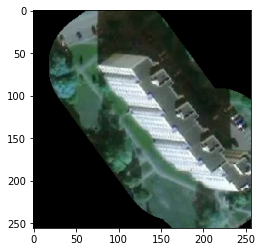

tensor(9.)


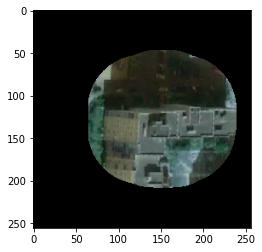

tensor(6.)


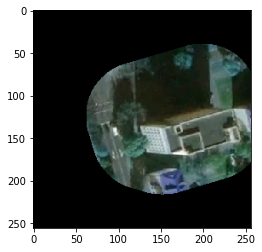

  0%|                                                   | 0/256 [00:00<?, ?it/s]

1->2 27.518531799316406
1->3 63.02642059326172
ACC= 1.0


In [33]:
# Lets look at data we have
show_im = True
random.shuffle(valid_dataset_list_f)
full_valid_dataset = ClRegDataset(valid_dataset_list_f, valid_dataset_dict_f)

results = []
for i in trange(256):
    image, level, pimage, plevel, nimage, nlevel = full_valid_dataset[random.randint(0, len(full_valid_dataset))] # get some sample
    if show_im:
        print(level)
        plt.imshow(image.numpy().astype('uint8'))
        plt.show()

        print(plevel)
        plt.imshow(pimage.numpy().astype('uint8'))
        plt.show()

        print(nlevel)
        plt.imshow(nimage.numpy().astype('uint8'))
        plt.show()

    image, pimage, nimage = torch.unsqueeze(image.to(device), 0), torch.unsqueeze(pimage.to(device), 0), torch.unsqueeze(nimage.to(device), 0)
    image, pimage, nimage = torch.transpose(image, 1, 3), torch.transpose(pimage, 1, 3), torch.transpose(nimage, 1, 3)
    fm1 = net(image)
    fm2 = net(pimage)
    fm3 = net(nimage)

    pos_dist = float(calc_euclidean(fm1, fm2))
    neg_dist = float(calc_euclidean(fm1, fm3))
    if pos_dist < neg_dist:
        results.append(1)
    else:
        results.append(0)
    if show_im:
        print('1->2', pos_dist)
        print('1->3', neg_dist)
        break
print('ACC=', sum(results) / len(results))